In this notebook I try to fit a small CNN to the extracted faces to see if it is easy to get about the same score than with boosting on the meta features

# Importing the faces

In [1]:
import tensorflow as tf
import time
%matplotlib inline

In [2]:
from scipy.ndimage import imread

In [3]:
from PIL import Image
#img = Image.open(image_file)
#image_data = np.array(img).astype(float)

In [4]:
import os
import matplotlib.pyplot as plt
from scipy import misc
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from spearman import score_function
import time

all_faces = {int(number[::-1][4:][::-1]): "data/extracted_faces/" + number
                  for number in os.listdir("data/extracted_faces")
                  if number[::-1][:4] == 'gpj.'}

bw = np.array(Image.open(all_faces[1])).astype(float)
bw = bw.mean(axis=2)/255.  # black and white normalized
bw = bw.reshape((-1,))  # 10k features

X = np.zeros((len(all_faces), 10**4))

for i in range(13000):
    if i % 1000==0:
        print i
    im = np.array(Image.open(all_faces[i+1])).astype(float)
    if len(im.shape)>2:
        X[i,:] =  im.mean(axis=2).reshape((-1,))/255.
    else:
        X[i,:] = im.reshape((-1,)) / 255.


# read .csv using pandas
y = pd.read_csv("data/training_outputs.csv", delimiter=";").set_index("ID")
y = y.as_matrix()

# store id's
X_ids = range(1, 13001)

# cut into test, train
X_train, X_test, y_train, y_test = train_test_split(X[0:10000], y, test_size=0.05, random_state=42)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [5]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

### Real tuto

In [6]:
import tensorflow as tf
tf.reset_default_graph()
config = tf.ConfigProto()
# config.device_count = {'GPU': 0}
config.gpu_options.allow_growth = True
config.log_device_placement=True
sess = tf.InteractiveSession(config=config)
#sess = tf.InteractiveSession()

# Multilayer convnet

In [7]:
x = tf.placeholder(tf.float32, shape=[None, 10000])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

In [8]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [9]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [10]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [11]:
x_image = tf.reshape(x, [-1,100,100,1])

In [12]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [13]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [14]:
W_fc1 = weight_variable([25 * 25 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 25*25*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [15]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [16]:
W_fc2 = weight_variable([1024, 1])
b_fc2 = bias_variable([1])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [17]:
mse = tf.reduce_mean((y_conv - y_)**2)
train_step = tf.train.AdamOptimizer(1e-4).minimize(mse)

In [18]:
sess.run(tf.global_variables_initializer())

In [19]:
mse.eval(feed_dict={
        x:X_train[0:500,:],y_: y_train[0:500,:], keep_prob: 1.0})

744.60876

In [20]:
type(X_train[0,0])

numpy.float32

In [21]:
starts = time.time()
for global_it in range(50):
    for i in range(95):
        batch = (X_train[(i*100):((i+1)*100),:], y_train[(i*100):((i+1)*100),:])
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    train_mse = sess.run(mse, feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    print "iteration %d, training mse %g"%(global_it, train_mse),
    print "test mse %g"%mse.eval(feed_dict={x: X_test, y_: y_test, keep_prob: 1.0}),
    
    # compute spearman
    preds = y_conv.eval(feed_dict={x: X_test, keep_prob: 1.0})
    current_spearman = score_function(y_pred=np.round(preds), y_true=y_test[0:500,:])
    print "test spearman %g"%current_spearman
    
print "\nRunning time: ", time.time() - starts

iteration 0, training mse 16.6147 test mse 16.3898 test spearman 0.326033
iteration 1, training mse 14.3459 test mse 15.286 test spearman 0.391381
iteration 2, training mse 14.3847 test mse 15.3581 test spearman 0.418178
iteration 3, training mse 14.4962 test mse 15.1404 test spearman 0.416715
iteration 4, training mse 13.5595 test mse 14.7254 test spearman 0.419291
iteration 5, training mse 13.419 test mse 14.8611 test spearman 0.424282
iteration 6, training mse 12.9489 test mse 14.492 test spearman 0.432117
iteration 7, training mse 13.3761 test mse 14.9488 test spearman 0.421605
iteration 8, training mse 12.7133 test mse 14.3472 test spearman 0.429322
iteration 9, training mse 12.383 test mse 14.4634 test spearman 0.440675
iteration 10, training mse 11.9837 test mse 14.3948 test spearman 0.455497
iteration 11, training mse 11.9337 test mse 14.4951 test spearman 0.45926
iteration 12, training mse 11.2412 test mse 14.2527 test spearman 0.464904
iteration 13, training mse 11.102 test m

In [22]:
print("test mse %g"%mse.eval(feed_dict={
    x: X_test[0:500], y_: y_test[0:500], keep_prob: 1.0}))

test mse 14.8548


In [23]:
preds = np.array([[]]).reshape((-1,1))
for i in range(30):
    preds = np.vstack((
        preds, 
        y_conv.eval(feed_dict={x: X_test[(i*100):((i+1)*100),:], y_: y_test[(i*100):((i+1)*100),:], keep_prob: 1.0})
    ))

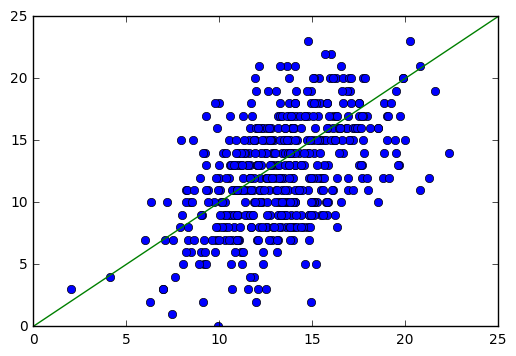

In [24]:
plt.plot(preds, y_test, "o")
plt.plot([0, 25], [0, 25])

In [25]:
from spearman import score_function

In [26]:
score_function(y_pred=np.round(preds), y_true=y_test)

0.48983326575821112